In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd 
import torch
from sentence_transformers import models, losses, evaluation, SentenceTransformer
import os
import json
from transformers import BertJapaneseTokenizer, BertModel
import pickle

from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold

2022-11-19 11:00:55.322539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 11:00:56.548958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-19 11:00:56.549062: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-19 11:00:56.699382: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-19 11:00:59.908212: W tensorflow/stream_executor/platform/de

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold


from sklearn.preprocessing import StandardScaler

from modules import meishi,wakachi
import mojimoji

In [3]:
from modules import one_hot, ShowList,makeAug, CSVfordf, sBERT_model,use_sBERT_model
from modules import label_encording, Add_class_wight,run_LGBM, make_nn_model
from modules import use_fasttext_model, make_results, model_evaluation, FI_LGBM

In [ ]:
df = CSVfordf('CorrectedDatanew.csv')

In [ ]:
#diagnosisのみ変形語
df.to_csv("CSVs/data(diagnosi).csv")

### purpose（文書）の変形 
### １sentenceBERT

In [ ]:
df = pd.read_csv("CSVs/data(diagnosi).csv")

In [ ]:
df=df[:50]

In [ ]:
model = sBERT_model("../data/model/strf_sonoisa_sentence-bert-base-ja-mean-tokens-v232.75.10")

In [9]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 75, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (dense): Dense({'in_features': 768, 'out_features': 139, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
)

In [10]:
df = use_sBERT_model(df , model, 'CSVs/sBERT_data.csv')

### purpose（文書）の変形 
### 2fasttext

In [ ]:
df = pd.read_csv("CSVs/data(diagnosi).csv")
df=df[:50]

In [ ]:
df = use_fasttext_model(df, "../data/model/fasttext_meishi_model.bin", 'CSVs/fasttext_data.csv')

### データセットfasttextに変換

In [4]:
#df_sBERT=pd.read_csv("CSVs/sBERT_data.csv")
df_ft=pd.read_csv("CSVs/ft_data.csv")

df_sBERT=df_sBERT.drop(["Unnamed: 0",'Unnamed: 0.1', 'purpose', 'diagnosis',], axis=1)
#df_ft=df_ft.drop(["Unnamed: 0", 'purpose', 'diagnosis',], axis=1)
#pd.set_option("display.max_rows", None, "display.max_columns", None)

### データセットsBERTに変換

In [4]:
df_sBERT=pd.read_csv("CSVs/sBERT_data.csv")
#df_ft=pd.read_csv("CSVs/ft_data.csv")

df_sBERT=df_sBERT.drop(["Unnamed: 0",'Unnamed: 0.1', 'purpose', 'diagnosis',], axis=1)
#df_ft=df_ft.drop(["Unnamed: 0", 'purpose', 'diagnosis',], axis=1)
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [8]:
#学習データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y
                                                   )

### Kfold_LBGM
#https://an-engineer-note.com/?p=312

In [19]:
# 5-fold CVモデルの学習
# 5つのモデルを保存するリストの初期化
models = []

train_results = [] #学習の経過を保存する箱のまとめ

# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=0)

categorical_features = {*sorted(['pos_lbl', 'sec_lbl'])}

In [20]:
# KFoldクラスで分割した回数だけ実行（ここでは5回）
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]
    #不均衡データの重み
    w_array=Add_class_wight(X_train_cv,  y_train_cv) 
    
    model, result = run_LGBM(X_train_cv, y_train_cv,X_eval_cv, y_eval_cv ,CF=categorical_features, CW=w_array)
    
    models.append(model)
    train_results.append(result)

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and w

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 20, number of used features: 246
[LightGBM] [Info] Start training from score -1.098490
[LightGBM] [Info] Start training from score -1.098856
[LightGBM] [Info] Start training from score -1.098490
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score 

In [21]:
models

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


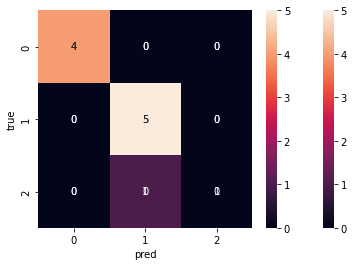

In [22]:
results, reports = model_evaluation(models, X_test, y_test, method='LGBM')

In [13]:
reports[0]

,precision,recall,f1-score,support
0,1.0,1.0,1.0,4.0
1,1.0,1.0,1.0,5.0
2,1.0,1.0,1.0,1.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,10.0
weighted avg,1.0,1.0,1.0,10.0


In [17]:
results[1]

,true,pred
0,1,1
1,0,0
2,0,0
3,0,0
4,1,1
5,1,1
6,1,1
7,0,0
8,2,1
9,1,1


In [15]:
Is = FI_LGBM(models, X)
Is[1]

,importance
year,112
男,2
女,1
単純,2
造影,0
...,...
P(S)vec136,0
P(S)vec137,0
P(S)vec138,0
sec_lbl,0


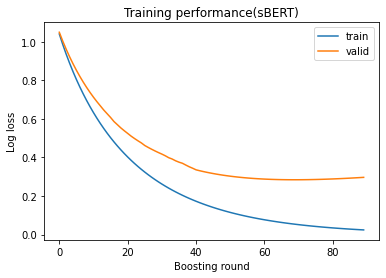

In [26]:
# 学習過程の可視化
plt.plot(train_results[0]['train']['multi_logloss'], label='train')
plt.plot(train_results[0]['valid']['multi_logloss'], label='valid')
plt.ylabel('Log loss')
plt.xlabel('Boosting round')
plt.title('Training performance(sBERT)')
plt.legend()
plt.show()

#https://potesara-tips.com/lightgbm-holdout/
#https://potesara-tips.com/lightgbm-k-fold-cross-validation/

### NN 5fold

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=ja

In [27]:
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Input
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

In [28]:
# Use a utility from sklearn to split and shuffle your dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y
                                                   )

In [29]:
#注意: StandardScalerはtrain_featuresを使用する場合にのみ適合し、モデルが検証セットやテストセットでピークを迎えることがないようにします。
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

X_train_ss = np.clip(X_train_ss, -5, 5)
X_test_ss = np.clip(X_test_ss, -5, 5)

In [30]:
#https://github.com/ghmagazine/kagglebook/blob/master/ch03/ch03-02-categorical.py
# target encoding - クロスバリデーションのfoldごとの場合
# クロスバリデーションのfoldごとにtarget encodingをやり直す
nn_models= []

histories = []
# 変換するカテゴリ変数をリストに格納
cat_cols = ['pos_lbl', 'sec_lbl']

class_num = 55

row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=0)




for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = pd.DataFrame(X_train_ss, columns=X_train.columns).iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = pd.DataFrame(X_train_ss, columns=X_train.columns).iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]
    
    w_array=Add_class_wight(X_train_cv,  y_train_cv)   
    print(len(w_array), len(X_train_cv))
    

    
    # 変数をループしてtarget encoding
    for c in cat_cols:
        # 学習データ全体で各カテゴリにおけるtargetの平均を計算
        data_tmp = pd.DataFrame({c: X_train_cv[c], 'target': y_train_cv})
        target_mean = data_tmp.groupby(c)['target'].mean()
        # バリデーションデータのカテゴリを置換
        X_eval_cv.loc[:, c] = X_eval_cv[c].map(target_mean)
        
        
        # 学習データの変換後の値を格納する配列を準備
        tmp = np.repeat(np.nan, X_train_cv.shape[0])
        
        # 学習データを分割(target encording)
        kf = KFold(n_splits=4, shuffle=True, random_state=0)
        
        kf_encoding = KFold(n_splits=4, shuffle=True, random_state=0)
        for idx_1, idx_2 in kf_encoding.split(X_train_cv):
            # out-of-foldで各カテゴリにおける目的変数の平均を計算
            target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
            # 変換後の値を一時配列に格納
            tmp[idx_2] = X_train_cv[c].iloc[idx_2].map(target_mean)

        X_train_cv.loc[:, c] = tmp
        
    
    model = make_nn_model(X_train, class_num)     

    early_stopping = tf.keras.callbacks.EarlyStopping( 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)
    
    EPOCHS = 10
    BATCH_SIZE = 20
    
    history = model.fit(
        X_train_cv,
        y_train_cv,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(X_eval_cv, y_eval_cv),
        #class_weight=w_array
    )
    
    y_eval_pred = model.predict(X_eval_cv)
    histories.append(history)
    nn_models.append(model) 
    #pd.DataFrame(history.history).plot(figsize=(8,5))    

20 20


2022-11-19 10:50:11.840688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-19 10:50:11.841279: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-19 10:50:11.841381: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3ed327de65ae): /proc/driver/nvidia/version does not exist
2022-11-19 10:50:11.842515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: nan - accuracy: 0.4000 - val_loss: nan - val_accuracy: 0.3500
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: nan - accuracy: 0.4000 - val_loss: nan - val_accuracy: 0.3500
Epoch 3/10
1/1 [==============================] - 0s 45ms/step - loss: nan - accuracy: 0.4000 - val_loss: nan - val_accuracy: 0.3500
Epoch 4/10
1/1 [==============================] - 0s 45ms/step - loss: nan - accuracy: 0.4000 - val_loss: nan - val_accuracy: 0.3500
Epoch 5/10
1/1 [==============================] - 0s 43ms/step - loss: nan - accuracy: 0.4000 - val_loss: nan - val_accuracy: 0.3500
Epoch 6/10
1/1 [==============================] - 0s 44ms/step - loss: nan - accuracy: 0.4000 - val_loss: nan - val_accuracy: 0.3500
Epoch 7/10
1/1 [==============================] - 0s 44ms/step - loss: nan - accuracy: 0.4000 - val_loss: nan - val_accuracy: 0.3500
Epoch 8/10
1/1 [==============================] - 0s 46ms/step - loss: 

1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

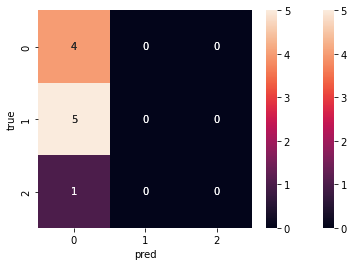

In [31]:
results, reports = model_evaluation(nn_models, X_test, y_test, method='NN')

In [32]:
results[0]

,true,pred
0,1,0
1,0,0
2,0,0
3,0,0
4,1,0
5,1,0
6,1,0
7,0,0
8,2,0
9,1,0


<AxesSubplot:>

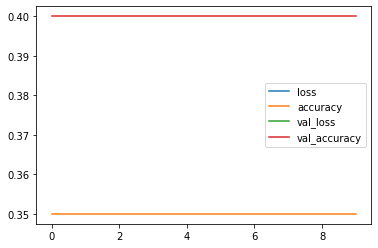

In [34]:
pd.DataFrame(histories[1].history).plot(figsize=(6,4))

<AxesSubplot:>

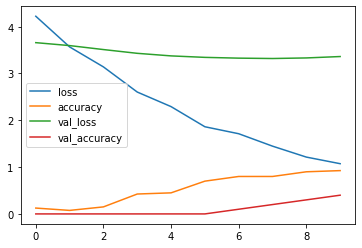

In [163]:
pd.DataFrame(history.history).plot(figsize=(6,4))

In [164]:
y_pred = models[0].predict(X_test)
print(len(y_pred))
np.argmax(y_pred, axis=1)

1/1 [==============================] - 0s 22ms/step
10


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [165]:
y_train

array([1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0])

In [166]:
y_test

array([1, 0, 0, 0, 1, 1, 1, 0, 2, 1])

In [167]:
y_pred_max

array([9, 0, 0, 0, 9, 0, 9, 0, 0, 0])

In [168]:
pd.DataFrame(list(zip(y_test, y_pred_max)), columns = ['true','pred'])

,true,pred
0,1,9
1,0,0
2,0,0
3,0,0
4,1,9
5,1,0
6,1,9
7,0,0
8,2,0
9,1,0


In [169]:
def make_results(y_pred, y_true):
    y_pred_max = np.argmax(y_pred, axis=1)
    df_result = pd.DataFrame(list(zip(y_test, y_pred_max)), columns = ['true','pred'])
    accuracy = sum(y_test == y_pred_max) / len(y_test)
    df_report = pd.DataFrame(classification_report(y_pred_max, y_test, 
                                               output_dict=True)).T
    
    sns.heatmap(confusion_matrix(result['true'],result['pred']), annot=True)
    plt.xlabel("pred")
    plt.ylabel('true')
    
    return (df_result, df_report)

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


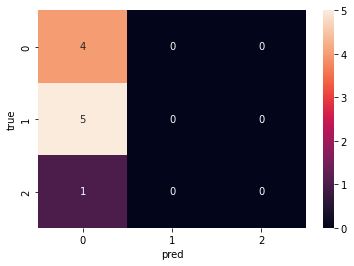

In [170]:
result, report = make_results(y_pred, y_test)

In [118]:
report

,precision,recall,f1-score,support
0,1.00,0.571429,0.727273,7.0
1,0.00,0.000000,0.000000,0.0
2,0.00,0.000000,0.000000,0.0
9,0.00,0.000000,0.000000,3.0
accuracy,0.40,0.400000,0.400000,0.4
macro avg,0.25,0.142857,0.181818,10.0
weighted avg,0.70,0.400000,0.509091,10.0


In [119]:
result

,true,pred
0,1,9
1,0,0
2,0,0
3,0,0
4,1,9
5,1,0
6,1,9
7,0,0
8,2,0
9,1,0


Text(33.0, 0.5, 'true')

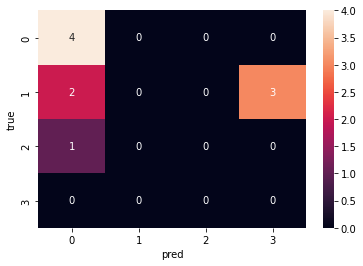

In [123]:
sns.heatmap(confusion_matrix(result['true'],result['pred']), annot=True)
plt.xlabel("pred")
plt.ylabel('true')